In [108]:
import sagemaker
import boto3
from datetime import datetime
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



from pyathena import connect

In [3]:
sess = sagemaker.Session() #Intialzie session

bucket = sess.default_bucket()
RD_Bucket = 'policedatasetbucket' #Raw Data
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3 = boto3.client('s3') # Create an S3 client
s3_resource = boto3.resource('s3') # Create an S3 resource


print('Bucket - > ',bucket)
print('Role - > ',role)
print('Region - > ',region)
print('S3 - > ',s3)
print('S3 Resource - > ',s3_resource)

Bucket - >  sagemaker-us-east-1-859074047513
Role - >  arn:aws:iam::859074047513:role/LabRole
Region - >  us-east-1
S3 - >  <botocore.client.S3 object at 0x7f9da3047890>
S3 Resource - >  s3.ServiceResource()


In [4]:
# Function to verify if bucket exist, if not create
def verify_create_bucket(bucket_name):
    response = s3.list_buckets()
    for bucket in response['Buckets']:
        if bucket['Name'] == bucket_name:
            print(f"The {bucket_name} bucket exists.")
            break
    else:
        print(f"The {bucket_name} bucket does not exist, creating")
        !aws s3 mb s3://{bucket}/

In [5]:
verify_create_bucket(bucket)

The sagemaker-us-east-1-859074047513 bucket exists.


In [6]:
#function to download yearly data
# def Get_Data(year):
#     url = f"https://seshat.datasd.org/pd/pd_calls_for_service_{year}_datasd.csv"
#     df = pd.read_csv(url)
#     return df

In [7]:
# List of years since 2018
# Years = list(range(2018,datetime.now().year+1))
# Years

In [8]:
#iterate over years
# for year in Years:
#     year_df = Get_Data(year)
#     csv_buffer = StringIO()
#     year_df.to_csv(csv_buffer, index=False)
#     file = 'SDPD_Calls_' + str(year) + '.csv'
#     s3_resource.Object(bucket,file).put(Body=csv_buffer.getvalue())
#     print(file,'loaded in',bucket,'bucket')

In [9]:
# def URL_2_Bucket(url,file_name):
#     df = pd.read_csv(url, low_memory=False)
#     csv_buffer = StringIO()
#     df.to_csv(csv_buffer, index=False)
#     file = file_name + '.csv'
#     s3_resource.Object(RD_Bucket,file).put(Body=csv_buffer.getvalue())
#     print(file,'loaded in',RD_Bucket,'bucket')
    

In [10]:
# type_url = f"http://seshat.datasd.org/pd/pd_cfs_calltypes_datasd.csv"
# dipo_url = f"http://seshat.datasd.org/pd/pd_dispo_codes_datasd.csv"
# ripa_stops_url = "https://seshat.datasd.org/pd/ripa_stops_datasd.csv"
# ripa_stops_dic = "https://seshat.datasd.org/pd/ripa_stops_dictionary_datasd.csv"

In [11]:
# URL_2_Bucket(type_url,'Type')
# URL_2_Bucket(dipo_url,'Dispo')
# URL_2_Bucket(ripa_stops_url,'Ripa_Stops')
# URL_2_Bucket(ripa_stops_dic,'Ripa_Stops_Dic')

In [12]:
ingest_create_athena_db_passed = False

# Create Athena Database

In [13]:
database_name = "sd_police_db"

In [14]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [15]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)


In [16]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS sd_police_db


In [17]:
import pandas as pd

pd.read_sql(statement, conn)

""


In [18]:
# Show databases
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,sd_police_db


# Drop Database if Needed

In [19]:
# drop_db_name = "dsoaw"
# drop_db_query = f"DROP DATABASE IF EXISTS {drop_db_name}"

# df_show = pd.read_sql(drop_db_query, conn)
# df_show.head()

# Drop Table if Needed

In [20]:
drop_table_name = "table_sd_ripa" 

drop_table_query = f"DROP TABLE IF EXISTS {database_name}.{drop_table_name}"

df_show1 = pd.read_sql(drop_table_query, conn)
df_show1.head()

""


In [21]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [22]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


# S3 Bucket Folder Information for 2019

In [23]:
# s3_private_path_csv19 = "s3://{}/SanDiego-Police-Dataset/policedataset19/csv".format(bucket)
# print(s3_private_path_csv19)

In [24]:
# table_name4 = "table_sd_2019"

In [25]:
# # SQL statement to execute
# statement_4 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
# incident_num string,
# date_time string,
# day_of_week string,
# address_number_primary string,
# address_dir_primary string,
# address_road_primary string,
# address_sfx_primary string,
# address_dir_intersecting string,
# address_road_intersecting string,
# address_sfx_intersecting string,
# call_type string,
# disposition string,
# beat string,
# priority string) 

# ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION '{}'
# TBLPROPERTIES ('skip.header.line.count'='1')""".format(database_name, table_name4, s3_private_path_csv19)

# print(statement_4)

In [26]:
# import pandas as pd

# pd.read_sql(statement_4, conn)

In [27]:
# database_name = "sd_police_db"
# statement = "SHOW TABLES in {}".format(database_name)

# df_show = pd.read_sql(statement, conn)

# df_show.head(6)

In [28]:
# pd.read_sql(statement_4, conn)

# df_2019 = pd.read_sql(f"SELECT * FROM {database_name}.{table_name4}", conn)

In [29]:
# df_2019

# S3 Bucket Folder Information for 2021

In [30]:
s3_private_path_csv = "s3://{}/SanDiego-Police-Dataset/policedatasetsd/csv".format(bucket)
print(s3_private_path_csv)

s3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/policedatasetsd/csv


In [31]:
table_name = "table_sd_2021"

In [32]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
incident_num string,
date_time string,
day_of_week int,
address_number_primary int,
address_dir_primary string,
address_road_primary string,
address_sfx_primary string,
address_dir_intersecting string,
address_road_intersecting string,
address_sfx_intersecting string,
call_type string,
disposition string,
beat int,
priority int) 

ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(database_name, table_name, s3_private_path_csv)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS sd_police_db.table_sd_2021(
incident_num string,
date_time string,
day_of_week int,
address_number_primary int,
address_dir_primary string,
address_road_primary string,
address_sfx_primary string,
address_dir_intersecting string,
address_road_intersecting string,
address_sfx_intersecting string,
call_type string,
disposition string,
beat int,
priority int) 

ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION 's3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/policedatasetsd/csv'
TBLPROPERTIES ('skip.header.line.count'='1')


In [33]:
import pandas as pd

pd.read_sql(statement, conn)

""


# Varify Tables in a Specified Database

In [34]:
database_name = "sd_police_db"
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)

df_show.head(5)

,tab_name
0,table_sd_2021
1,table_sd_2022
2,table_sd_2023


In [35]:
pd.read_sql(statement, conn)

df_2021 = pd.read_sql(f"SELECT * FROM {database_name}.{table_name}", conn)

# S3 Bucket Folder Information for 2022

In [36]:
s3_private_path_csv1 = "s3://{}/SanDiego-Police-Dataset/policedatasetsd22/csv".format(bucket)
print(s3_private_path_csv1)

s3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/policedatasetsd22/csv


In [37]:
table_name1 = "table_sd_2022"

In [38]:
# SQL statement to execute
statement_1 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
incident_num string,
date_time string,
day_of_week int,
address_number_primary int,
address_dir_primary string,
address_road_primary string,
address_sfx_primary string,
address_dir_intersecting string,
address_road_intersecting string,
address_sfx_intersecting string,
call_type string,
disposition string,
beat int,
priority int) 

ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(database_name, table_name1, s3_private_path_csv1)

print(statement_1)

CREATE EXTERNAL TABLE IF NOT EXISTS sd_police_db.table_sd_2022(
incident_num string,
date_time string,
day_of_week int,
address_number_primary int,
address_dir_primary string,
address_road_primary string,
address_sfx_primary string,
address_dir_intersecting string,
address_road_intersecting string,
address_sfx_intersecting string,
call_type string,
disposition string,
beat int,
priority int) 

ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION 's3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/policedatasetsd22/csv'
TBLPROPERTIES ('skip.header.line.count'='1')


In [39]:
import pandas as pd

pd.read_sql(statement_1, conn)

""


In [40]:
database_name = "sd_police_db"
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,table_sd_2021
1,table_sd_2022
2,table_sd_2023


In [41]:
pd.read_sql(statement_1, conn)

df_2022 = pd.read_sql(f"SELECT * FROM {database_name}.{table_name1}", conn)

In [42]:
df_2022

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E22070002550,2022-07-02 17:54:21,7,0,None,GENESEE,AVE,None,SR-52,None,HZRD,K,114,1
1,E22070002551,2022-07-02 17:55:07,7,2400,None,BROADWAY,None,None,None,None,242,K,517,1
2,E22070002552,2022-07-02 17:56:53,7,5000,None,SOLEDAD MOUNTAIN,RD,None,None,None,MPSSTP,K,122,2
3,E22070002553,2022-07-02 17:57:26,7,800,None,SHERMAN,ST,None,None,None,602,K,622,2
4,E22070002555,2022-07-02 17:59:11,7,1000,None,UNIVERSITY,AVE,None,None,None,242R,K,627,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499251,E22060041414,2022-06-29 11:38:55,4,4100,None,54TH,PL,None,None,None,594,R,822,2
499252,E22060041415,2022-06-29 11:38:57,4,5000,None,SANTA MONICA,AVE,None,None,None,242,R,614,1
499253,E22060041416,2022-06-29 11:40:20,4,4800,None,DEL MAR,AVE,None,None,None,INFO,K,614,2
499254,E22060041417,2022-06-29 11:41:47,4,300,None,05TH,AVE,None,None,None,1186,K,523,3


# S3 Bucket Folder Information for 2023

In [43]:
s3_private_path_csv2 = "s3://{}/SanDiego-Police-Dataset/policedatasetsd23/csv".format(bucket)
print(s3_private_path_csv2)

s3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/policedatasetsd23/csv


In [44]:
table_name2 = "table_sd_2023"

In [45]:
# SQL statement to execute
statement_2 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
incident_num string,
date_time string,
day_of_week int,
address_number_primary int,
address_dir_primary string,
address_road_primary string,
address_sfx_primary string,
address_dir_intersecting string,
address_road_intersecting string,
address_sfx_intersecting string,
call_type string,
disposition string,
beat int,
priority int) 

ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1',
                'serialization.null.format'='')""".format(database_name, table_name2, s3_private_path_csv2)

print(statement_2)

CREATE EXTERNAL TABLE IF NOT EXISTS sd_police_db.table_sd_2023(
incident_num string,
date_time string,
day_of_week int,
address_number_primary int,
address_dir_primary string,
address_road_primary string,
address_sfx_primary string,
address_dir_intersecting string,
address_road_intersecting string,
address_sfx_intersecting string,
call_type string,
disposition string,
beat int,
priority int) 

ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' NULL DEFINED AS '' LOCATION 's3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/policedatasetsd23/csv'
TBLPROPERTIES ('skip.header.line.count'='1',
                'serialization.null.format'='')


In [46]:
import pandas as pd

pd.read_sql(statement_2, conn)

""


In [47]:
database_name = "sd_police_db"
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,table_sd_2021
1,table_sd_2022
2,table_sd_2023


In [48]:
pd.read_sql(statement_2, conn)

df_2023 = pd.read_sql(f"SELECT * FROM {database_name}.{table_name2}", conn)

In [49]:
df_2023

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E23010004824,2023-01-04 15:59:54,4,5500,None,OTAY MESA,RD,None,None,None,586,O,725,4
1,E23010004825,2023-01-04 16:00:10,4,500,None,13TH,ST,None,None,None,415,K,521,2
2,E23010004826,2023-01-04 16:00:37,4,0,None,48TH,ST,None,TROJAN,None,CW,K,826,1
3,E23010004827,2023-01-04 16:00:50,4,6800,None,CARTHAGE,ST,None,None,None,415V,A,322,1
4,E23010004828,2023-01-04 16:01:24,4,2700,None,WORDEN,ST,None,None,None,415,K,613,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99806,E23030022386,2023-03-15 23:25:50,4,2500,None,IMPERIAL,AVE,None,None,None,INFO,K,512,2
99807,E23030022400,2023-03-15 23:44:05,4,800,None,27TH (SB),ST,None,None,None,5150,K,724,1
99808,E23030022401,2023-03-15 23:44:23,4,14700,None,VALLE DEL SUR,CT,None,None,None,459A,CAN,937,2
99809,E23030022404,2023-03-15 23:46:26,4,400,None,17TH,ST,None,None,None,SELENF,K,521,3


# S3 Bucket Folder Information for RIPA Dataset

In [50]:
s3_private_path_csv_ripa = "s3://{}/SanDiego-Police-Dataset/ripapolicedatasetsd/csv".format(bucket)
print(s3_private_path_csv_ripa)

s3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/ripapolicedatasetsd/csv


In [51]:
table_name3 = "table_sd_ripa"

In [52]:
# SQL statement to execute
statement_3 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
`stop_id` string,
`ori` string,
`agency` string,
`exp_years` string,
`date_stop` string,
`time_stop` string,
`stopduration` string,
`stop_in_response_to_cfs` string,
`office_assignment_key` string,
`assignment` string,
`intersection` string,
`address_block` string,
`land_mark` string,
`address_street` string,
`highway_exit` string,
`isschool` string,
`school_name` string,
`address_city` string,
`beat` string,
`beat_name` string,
`pid` string,
`isstudent` string,
`perceived_limited_english` string,
`perceived_age` string,
`perceived_gender` string,
`gender_nonconforming` string,
`gend` string,
`gend_nc` string,
`perceived_lgbt` string
) 

ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES ("separatorChar" = ",")
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1',
               'serialization.null.format'='')""".format(database_name, table_name3, s3_private_path_csv_ripa)


print(statement_3)

CREATE EXTERNAL TABLE IF NOT EXISTS sd_police_db.table_sd_ripa(
`stop_id` string,
`ori` string,
`agency` string,
`exp_years` string,
`date_stop` string,
`time_stop` string,
`stopduration` string,
`stop_in_response_to_cfs` string,
`office_assignment_key` string,
`assignment` string,
`intersection` string,
`address_block` string,
`land_mark` string,
`address_street` string,
`highway_exit` string,
`isschool` string,
`school_name` string,
`address_city` string,
`beat` string,
`beat_name` string,
`pid` string,
`isstudent` string,
`perceived_limited_english` string,
`perceived_age` string,
`perceived_gender` string,
`gender_nonconforming` string,
`gend` string,
`gend_nc` string,
`perceived_lgbt` string
) 

ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES ("separatorChar" = ",")
LOCATION 's3://sagemaker-us-east-1-859074047513/SanDiego-Police-Dataset/ripapolicedatasetsd/csv'
TBLPROPERTIES ('skip.header.line.count'='1',
               'serialization.null.format

In [53]:
import pandas as pd

pd.read_sql(statement_3, conn)

""


In [54]:
database_name = "sd_police_db"
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,table_sd_2021
1,table_sd_2022
2,table_sd_2023
3,table_sd_ripa


In [55]:
pd.read_sql(statement_3, conn)

ripa_df = pd.read_sql(f"SELECT * FROM {database_name}.{table_name3}", conn)

In [56]:
police_call_df = pd.read_sql(f"SELECT * FROM {database_name}.{table_name} UNION ALL \
                               SELECT * FROM {database_name}.{table_name1} UNION ALL \
                               SELECT * FROM {database_name}.{table_name2} LIMIT 20", conn)

In [57]:
police_call_df

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E21010000001,2021-01-01 00:00:11,6,5000,None,CHAPARRAL,WAY,None,None,None,AU1,W,326,1
1,E21010000002,2021-01-01 00:00:14,6,500,None,05TH,AVE,None,None,None,1186,CAN,523,3
2,E21010000003,2021-01-01 00:00:26,6,3600,None,38TH,ST,None,None,None,AU1,DUP,839,1
3,E21010000004,2021-01-01 00:00:31,6,2700,None,WORDEN,ST,None,None,None,AU1,W,613,1
4,E21010000006,2021-01-01 00:01:20,6,800,None,SAN DIEGO,PL,None,None,None,INFO,W,121,2
5,E21010000007,2021-01-01 00:01:41,6,8500,None,LAKE MURRAY,BLV,None,None,None,FIREHZRD,CAN,324,2
6,E21010000008,2021-01-01 00:02:19,6,5400,None,CHURCHWARD,ST,None,None,None,1131A,U,432,1
7,E21010000009,2021-01-01 00:03:06,6,0,None,INFO LOG,None,None,None,None,503CAR,W,-1,2
8,E21010000010,2021-01-01 00:03:38,6,0,None,SHOPS INFO LOG,None,None,None,None,SHOPS,W,-1,4
9,E21010000011,2021-01-01 00:03:44,6,0,None,38TH,ST,None,UNIVERSITY,None,AU1,DUP,838,1


In [58]:
ripa_sql_df = pd.read_sql(f"SELECT beat, beat_name, COUNT(beat) Incident_count FROM {database_name}.{table_name3} WHERE date_stop >= '2021-01-01' GROUP BY beat, beat_name", conn) 

In [59]:
ripa_sql_df

,beat,beat_name,Incident_count
0,825,Kensington 825,638
1,442,Southcrest 442,1229
2,614,Ocean Beach 614,5828
3,813,North Park 813,4881
4,121,Mission Beach 121,3732
...,...,...,...
124,323,Del Cerro 323,1213
125,824,Talmadge 824,1156
126,437,Bay Terraces 437,1748
127,841,Rolando Park 841,320


In [60]:
# main_df = pd.read_sql(f"SELECT * FROM (SELECT * FROM {database_name}.{table_name} UNION ALL \
#                                        SELECT * FROM {database_name}.{table_name1} UNION ALL \
#                                        SELECT * FROM {database_name}.{table_name2}) Q1 LEFT JOIN (SELECT beat, beat_name, COUNT(beat) Incident_count FROM {database_name}.{table_name3} \
#                                        WHERE date_stop >= 2021-01-01 GROUP BY beat, beat_name) Q2 ON Q1.beat = Q2.beat", conn) 

# Join The Three datasets 2021, 2022, 2023

### Checking the data types, removing missing values, duplicated values

In [61]:
# shape of the dataframes
print(f'shape of the dataframe police dataframe {df_2021.shape}')
print(f'shape of the dataframe police dataframe {df_2022.shape}')
print(f'shape of the dataframe police dataframe {df_2023.shape}')

shape of the dataframe police dataframe (568947, 14)
shape of the dataframe police dataframe (499256, 14)
shape of the dataframe police dataframe (99811, 14)


In [62]:
# concatenate the tables 
join_df = pd.concat([df_2021, df_2022, df_2023], axis=0)
join_df

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E21060051577,2021-06-30 19:59:30,4,2500,None,SUNSET CLIFFS,BLV,None,None,None,SLEEPER,K,614,3
1,E21060051578,2021-06-30 20:00:14,4,7100,None,TERRA COTTA,RD,None,None,None,415V,K,437,1
2,E21060051579,2021-06-30 20:00:52,4,5600,None,KEARNY MESA,RD,None,None,None,DRAGNET,O,313,1
3,E21060051580,2021-06-30 20:01:20,4,1900,None,MAIN,ST,None,None,None,602,K,511,2
4,E21060051581,2021-06-30 20:02:13,4,2000,None,COMMERCIAL,ST,None,None,None,1186,K,512,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99806,E23030022386,2023-03-15 23:25:50,4,2500,None,IMPERIAL,AVE,None,None,None,INFO,K,512,2
99807,E23030022400,2023-03-15 23:44:05,4,800,None,27TH (SB),ST,None,None,None,5150,K,724,1
99808,E23030022401,2023-03-15 23:44:23,4,14700,None,VALLE DEL SUR,CT,None,None,None,459A,CAN,937,2
99809,E23030022404,2023-03-15 23:46:26,4,400,None,17TH,ST,None,None,None,SELENF,K,521,3


In [63]:
join_df["beat"].nunique()

130

In [64]:
join_df.describe(include='all')

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
count,1168014,1168014,1.168014e+06,1.168014e+06,55064,1167818,1067996,0,196743,0,1166864,1164029,1.168014e+06,1.168014e+06
unique,1168014,1157922,NaN,NaN,9,12704,42,0,6234,0,251,19,NaN,NaN
top,E22050002222,2021-01-01 15:22:30,NaN,NaN,W,IMPERIAL,ST,NaN,MARKET,NaN,415,K,NaN,NaN
freq,1,3,NaN,NaN,19522,21385,348278,NaN,5374,NaN,102096,608343,NaN,NaN
mean,NaN,NaN,4.047912e+00,3.359414e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.928137e+02,2.153036e+00
std,NaN,NaN,1.959082e+00,3.388304e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.403017e+02,1.321955e+00
min,NaN,NaN,1.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,0.000000e+00
25%,NaN,NaN,2.000000e+00,5.000000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.130000e+02,1.000000e+00
50%,NaN,NaN,4.000000e+00,2.700000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.210000e+02,2.000000e+00
75%,NaN,NaN,6.000000e+00,4.800000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.270000e+02,3.000000e+00


In [65]:
# Data types 
join_df.dtypes

incident_num                 object
date_time                    object
day_of_week                   int64
address_number_primary        int64
address_dir_primary          object
address_road_primary         object
address_sfx_primary          object
address_dir_intersecting     object
address_road_intersecting    object
address_sfx_intersecting     object
call_type                    object
disposition                  object
beat                          int64
priority                      int64
dtype: object

In [66]:
from datetime import datetime

join_df["date_time"] = pd.to_datetime(join_df["date_time"])
join_df

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E21060051577,2021-06-30 19:59:30,4,2500,None,SUNSET CLIFFS,BLV,None,None,None,SLEEPER,K,614,3
1,E21060051578,2021-06-30 20:00:14,4,7100,None,TERRA COTTA,RD,None,None,None,415V,K,437,1
2,E21060051579,2021-06-30 20:00:52,4,5600,None,KEARNY MESA,RD,None,None,None,DRAGNET,O,313,1
3,E21060051580,2021-06-30 20:01:20,4,1900,None,MAIN,ST,None,None,None,602,K,511,2
4,E21060051581,2021-06-30 20:02:13,4,2000,None,COMMERCIAL,ST,None,None,None,1186,K,512,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99806,E23030022386,2023-03-15 23:25:50,4,2500,None,IMPERIAL,AVE,None,None,None,INFO,K,512,2
99807,E23030022400,2023-03-15 23:44:05,4,800,None,27TH (SB),ST,None,None,None,5150,K,724,1
99808,E23030022401,2023-03-15 23:44:23,4,14700,None,VALLE DEL SUR,CT,None,None,None,459A,CAN,937,2
99809,E23030022404,2023-03-15 23:46:26,4,400,None,17TH,ST,None,None,None,SELENF,K,521,3


In [67]:
join_df.dtypes

incident_num                         object
date_time                    datetime64[ns]
day_of_week                           int64
address_number_primary                int64
address_dir_primary                  object
address_road_primary                 object
address_sfx_primary                  object
address_dir_intersecting             object
address_road_intersecting            object
address_sfx_intersecting             object
call_type                            object
disposition                          object
beat                                  int64
priority                              int64
dtype: object

In [68]:
join_df.sort_values(by="date_time", ascending = True)

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
8941,E21010000001,2021-01-01 00:00:11,6,5000,None,CHAPARRAL,WAY,None,None,None,AU1,W,326,1
8942,E21010000002,2021-01-01 00:00:14,6,500,None,05TH,AVE,None,None,None,1186,CAN,523,3
8943,E21010000003,2021-01-01 00:00:26,6,3600,None,38TH,ST,None,None,None,AU1,DUP,839,1
8944,E21010000004,2021-01-01 00:00:31,6,2700,None,WORDEN,ST,None,None,None,AU1,W,613,1
8945,E21010000006,2021-01-01 00:01:20,6,800,None,SAN DIEGO,PL,None,None,None,INFO,W,121,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99806,E23030022386,2023-03-15 23:25:50,4,2500,None,IMPERIAL,AVE,None,None,None,INFO,K,512,2
99807,E23030022400,2023-03-15 23:44:05,4,800,None,27TH (SB),ST,None,None,None,5150,K,724,1
99808,E23030022401,2023-03-15 23:44:23,4,14700,None,VALLE DEL SUR,CT,None,None,None,459A,CAN,937,2
99809,E23030022404,2023-03-15 23:46:26,4,400,None,17TH,ST,None,None,None,SELENF,K,521,3


In [69]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168014 entries, 0 to 99810
Data columns (total 14 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   incident_num               1168014 non-null  object        
 1   date_time                  1168014 non-null  datetime64[ns]
 2   day_of_week                1168014 non-null  int64         
 3   address_number_primary     1168014 non-null  int64         
 4   address_dir_primary        55064 non-null    object        
 5   address_road_primary       1167818 non-null  object        
 6   address_sfx_primary        1067996 non-null  object        
 7   address_dir_intersecting   0 non-null        object        
 8   address_road_intersecting  196743 non-null   object        
 9   address_sfx_intersecting   0 non-null        object        
 10  call_type                  1166864 non-null  object        
 11  disposition                1164029 non-

Our first file contains 1,168,014 rows and 14 columns.</br>
Out of 14 columns 4 are int type, 8 are strings/object, and 1 is datetime type.</br>
Out of 14 columns 8 columns have null/missing values. 


In [70]:
# check null values
join_df.isna().sum()

incident_num                       0
date_time                          0
day_of_week                        0
address_number_primary             0
address_dir_primary          1112950
address_road_primary             196
address_sfx_primary           100018
address_dir_intersecting     1168014
address_road_intersecting     971271
address_sfx_intersecting     1168014
call_type                       1150
disposition                     3985
beat                               0
priority                           0
dtype: int64

In [71]:
from tqdm import tqdm

def Data_Quality_Report(df):

    #Initial table
    freqDF = pd.DataFrame(columns=['Feature',
                                   'Mode',
                                   'Mode Freq.',
                                   'Mode %',
                                   '2nd Mode',
                                   '2nd Mode Freq.',
                                   '2nd Mode %'])
    for col in tqdm(df.columns):
        try:
            #print(col)
            freq = df[col].value_counts()
            freqdf = freq.to_frame()
            fRow = freqdf.iloc[0]
            #try:
            secRow = freqdf.iloc[1]
            #except:
            #secRow = 0
            fPrct = fRow[0] / len(df[col])
            #try:
            secPrct = secRow[0] / len(df[col])
            #except:
                #secPrct = 0
            try:
                mode1 = int(fRow.name)
            except:
                mode1 = fRow.name
            try:
                mode2 = int(secRow.name)
            except:
                try:
                    mode2 = secRow.name
                except:
                    mode2 = 0
            freqDF = freqDF.append({'Feature':col,
                                    'Mode':mode1,
                                    'Mode Freq.':fRow[0],
                                    'Mode %':fPrct,\
                                    '2nd Mode':mode2,
                                    '2nd Mode Freq.':secRow[0],
                                    '2nd Mode %':secPrct},
                                    ignore_index=True)
        except:
            pass

    freqDF = freqDF.set_index('Feature')

    #Nulls, Counts, Cardinality
    NUllFeatures = round(df.isnull().sum() / df.shape[0],4)\
          .sort_values(ascending=False)
    Count = df.count()
    uni = df.nunique()

    #Formating
    NUllFeatures.to_frame(name="% Miss.")
    Count.to_frame(name="Count")
    uni.to_frame()
    result = pd.concat([Count, NUllFeatures,uni], axis=1)
    result.columns =["Count","% Miss.","Card."]
    result = pd.concat([result, freqDF], axis=1)
    """
    result = result.style.format({'% Miss.': "{:.1%}",
                         'Mode %': "{:.0%}",
                         '2nd Mode %': "{:.0%}",
                         'Count': "{:,}",
                         'Card.': "{:,}",
                         'Mode Freq.': "{:,}",
                        '2nd Mode Freq.': "{:,}"})"""
    return result

In [72]:
DQR_Calls = Data_Quality_Report(join_df)
DQR_Calls

100%|██████████| 14/14 [00:02<00:00,  5.05it/s]


,Count,% Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
incident_num,1168014,0.0000,1168014,E22050002222,1,8.561541e-07,E22060030974,1,8.561541e-07
date_time,1168014,0.0000,1157922,2021-08-26 11:35:37,3,2.568462e-06,2022-01-29 23:11:39,3,2.568462e-06
day_of_week,1168014,0.0000,7,5,175015,1.498398e-01,6,173878,1.488664e-01
address_number_primary,1168014,0.0000,262,0,212027,1.815278e-01,1400,24613,2.107252e-02
address_dir_primary,55064,0.9529,9,W,19522,1.671384e-02,S,17418,1.491249e-02
address_road_primary,1167818,0.0002,12704,IMPERIAL,21385,1.830886e-02,05TH,18939,1.621470e-02
address_sfx_primary,1067996,0.0856,42,ST,348278,2.981796e-01,AVE,275917,2.362275e-01
address_dir_intersecting,0,1.0000,0,NaN,NaN,NaN,NaN,NaN,NaN
address_road_intersecting,196743,0.8316,6234,MARKET,5374,4.600972e-03,UNIVERSITY,5072,4.342414e-03
address_sfx_intersecting,0,1.0000,0,NaN,NaN,NaN,NaN,NaN,NaN


As we can see the `address_sfx_intersecting` and `address_dir_intersecting` have no values and we can drop these columns.</br>
Also the `address_dir_primary` and `address_road_intersecting` have more than 80% missing values; therefore we can consider removing these columns too. 

### Dropping columns with more than 60% missing values

In [73]:
# Removing unnecessary columns
def drop_columns_with_max_missing_values(df):
    mis_var = [x for x in df.columns if df[x].isnull().sum() > 0]
    df[mis_var].isnull().sum()

    limit = np.abs((df.shape[0] * 0.6))
    var_to_be_dropped = [x for x in mis_var if df[x].isnull().sum() > limit]
    print('Columns with more than 60% missing values: \n\n', var_to_be_dropped)

    df.drop(columns=var_to_be_dropped, axis=1, inplace=True)
    return df

df = drop_columns_with_max_missing_values(join_df)

Columns with more than 60% missing values: 

 ['address_dir_primary', 'address_dir_intersecting', 'address_road_intersecting', 'address_sfx_intersecting']


In [74]:
join_df.shape

(1168014, 10)

We dropped the unnecesssary columns from the dataset

In [75]:
# check duplicated values
join_df.duplicated().sum()

0

We don't have any duplicated values in dataset

In [76]:
join_df.isnull().sum()

incident_num                   0
date_time                      0
day_of_week                    0
address_number_primary         0
address_road_primary         196
address_sfx_primary       100018
call_type                   1150
disposition                 3985
beat                           0
priority                       0
dtype: int64

In [77]:
join_df = join_df.dropna(axis=0)


In [78]:
join_df.isnull().sum()

incident_num              0
date_time                 0
day_of_week               0
address_number_primary    0
address_road_primary      0
address_sfx_primary       0
call_type                 0
disposition               0
beat                      0
priority                  0
dtype: int64

In [79]:
join_df.dtypes

incident_num                      object
date_time                 datetime64[ns]
day_of_week                        int64
address_number_primary             int64
address_road_primary              object
address_sfx_primary               object
call_type                         object
disposition                       object
beat                               int64
priority                           int64
dtype: object

# Bias Exploration 

***Priority Zero***: Dispatch Immediately. Priority E calls involve an imminent
threat to life. Examples include: officer or person down, no detail accidents and
attempted suicide.

***Priority On***e: Dispatch Immediately. Priority One calls involve serious crimes
in progress or a threat to life. Examples include: missing children, child abuse,
domestic violence, disturbances involving weapons/violence and bomb threats.

***Priority Two***: Dispatch as quickly as possible. Priority Two calls involve
complaints regarding less serious crimes in which there is no threat to life.
Examples include: prowlers who have left, preserve the peace, crime reports for
residents standing by at an inconvenient location, blocked driveway when the
caller is waiting to leave, injured animals, loud parties with mitigating
circumstances.

***Priority Three***: Dispatch as quickly as possible. Priority Three calls involve
minor crimes or requests for service which are not urgent. Examples include:
investigating a cold crime, loud parties involving noise only.

***Priority Four***: Dispatch when no higher priority calls are waiting. Priority
Four calls involve minor requests for police service. Examples include: found
property, most parking violations, etc.

***Priority Nine***: Calls that are formatted for the Telephone Report Unit (TRU).
Priority Nine calls involve requests for police service, which have limited or no
suspect information. Examples include: petty theft, vehicle break-in and false
use of another’s identity.

The dispatch priority system is designed to be only a guide as a higher or lower
priority may be more appropriate.

In [100]:
join_df["priority"] = join_df["priority"].astype("category")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


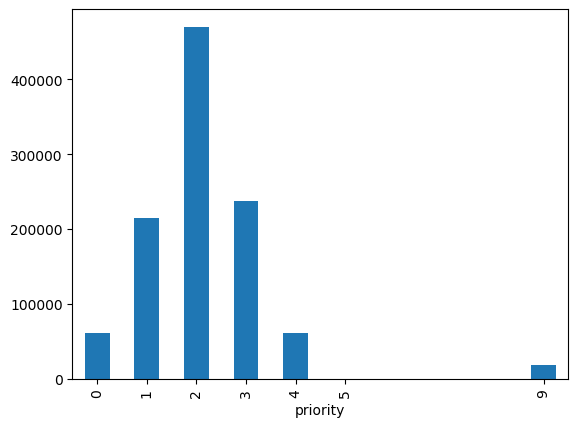

In [109]:
priority_df = join_df.groupby("priority").count()["incident_num"].plot(kind='bar')
plt.show()


Since we don't have priority `5` in our dictionary and it's not interpreted we can remove from our dataset. 

In [111]:
priority_5 = join_df[join_df["priority"]==5]
priority_5

,incident_num,date_time,day_of_week,address_number_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,priority
14852,E22070013676,2022-07-10 04:03:59,1,600,K,ST,488R,K,521,5
98770,E22010038843,2022-01-28 03:55:45,6,11400,NORTH TORREY PINES,RD,1186,R,126,5
100365,E22010040535,2022-01-29 05:45:53,7,11400,NORTH TORREY PINES,RD,1186,K,126,5
74240,E23020036542,2023-02-25 09:00:49,7,1000,10TH,AVE,SELENF,K,-1,5


In [112]:
join_df_clean = join_df.drop(join_df[join_df["priority"]==5].index) 

In [114]:
join_df_clean

,incident_num,date_time,day_of_week,address_number_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,priority
0,E21060051577,2021-06-30 19:59:30,4,2500,SUNSET CLIFFS,BLV,SLEEPER,K,614,3
1,E21060051578,2021-06-30 20:00:14,4,7100,TERRA COTTA,RD,415V,K,437,1
2,E21060051579,2021-06-30 20:00:52,4,5600,KEARNY MESA,RD,DRAGNET,O,313,1
3,E21060051580,2021-06-30 20:01:20,4,1900,MAIN,ST,602,K,511,2
4,E21060051581,2021-06-30 20:02:13,4,2000,COMMERCIAL,ST,1186,K,512,3
...,...,...,...,...,...,...,...,...,...,...
99806,E23030022386,2023-03-15 23:25:50,4,2500,IMPERIAL,AVE,INFO,K,512,2
99807,E23030022400,2023-03-15 23:44:05,4,800,27TH (SB),ST,5150,K,724,1
99808,E23030022401,2023-03-15 23:44:23,4,14700,VALLE DEL SUR,CT,459A,CAN,937,2
99809,E23030022404,2023-03-15 23:46:26,4,400,17TH,ST,SELENF,K,521,3


Text(0, 0.5, 'Incident Count')

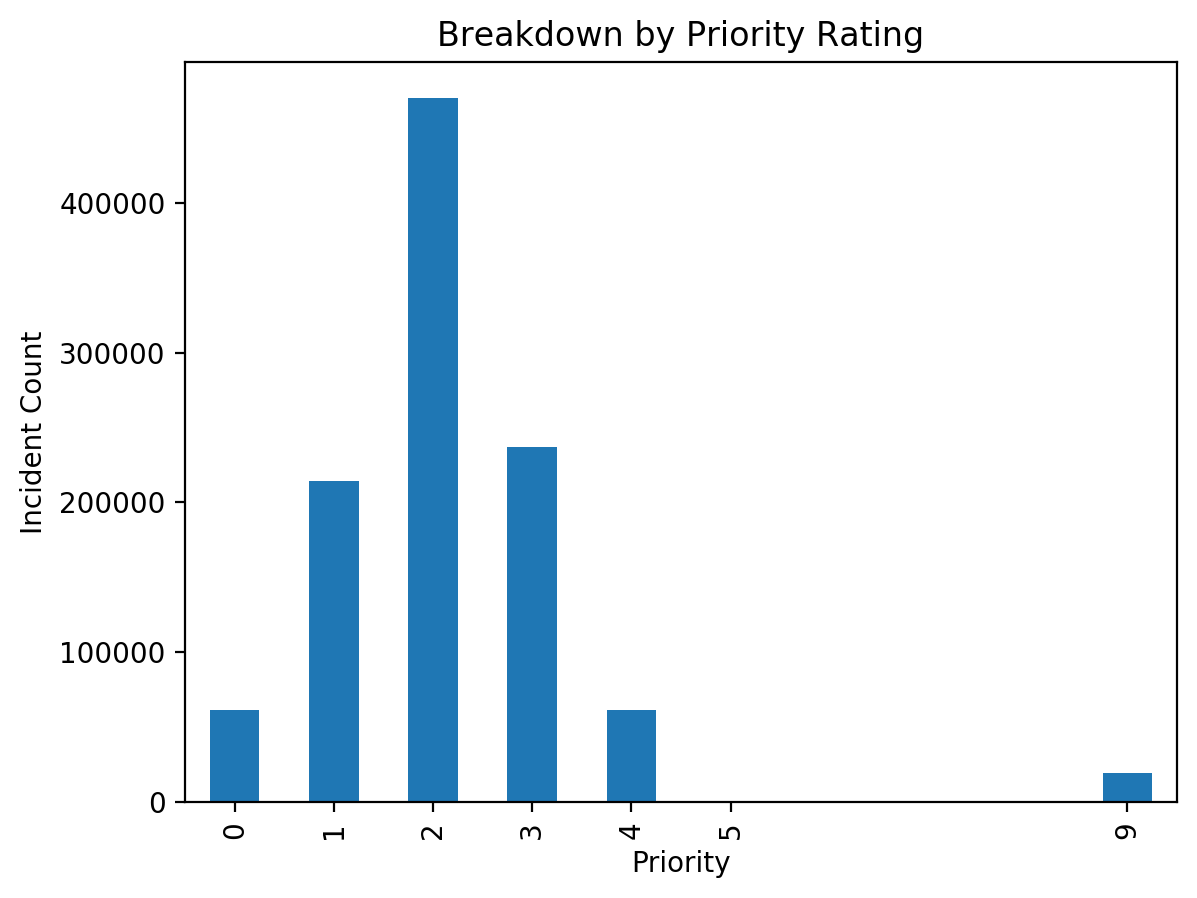

In [116]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

join_df_clean.groupby("priority").count()["incident_num"].plot(
    kind="bar", title="Breakdown by Priority Rating")

plt.xlabel("Priority")
plt.ylabel("Incident Count")

In [117]:
counts_pri = join_df_clean["priority"].value_counts()
counts_pri

2    470282
3    237197
1    214457
4     61352
0     61245
9     18994
5         0
Name: priority, dtype: int64

In [122]:
# Change the `priority` values to categorical

# create a dictionary to map old values to new values
priority_map = {0: 'Dispatch immediately', 1: 'Dispatch immediately', 2: 'Dispatch', 3: 'Dispatch', 4: 'non-urgent', 9: 'non-urgent'}
join_df_clean["priority"] = join_df_clean["priority"].replace(priority_map)
join_df_clean

,incident_num,date_time,day_of_week,address_number_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,priority
0,E21060051577,2021-06-30 19:59:30,4,2500,SUNSET CLIFFS,BLV,SLEEPER,K,614,Dispatch
1,E21060051578,2021-06-30 20:00:14,4,7100,TERRA COTTA,RD,415V,K,437,Dispatch immediately
2,E21060051579,2021-06-30 20:00:52,4,5600,KEARNY MESA,RD,DRAGNET,O,313,Dispatch immediately
3,E21060051580,2021-06-30 20:01:20,4,1900,MAIN,ST,602,K,511,Dispatch
4,E21060051581,2021-06-30 20:02:13,4,2000,COMMERCIAL,ST,1186,K,512,Dispatch
...,...,...,...,...,...,...,...,...,...,...
99806,E23030022386,2023-03-15 23:25:50,4,2500,IMPERIAL,AVE,INFO,K,512,Dispatch
99807,E23030022400,2023-03-15 23:44:05,4,800,27TH (SB),ST,5150,K,724,Dispatch immediately
99808,E23030022401,2023-03-15 23:44:23,4,14700,VALLE DEL SUR,CT,459A,CAN,937,Dispatch
99809,E23030022404,2023-03-15 23:46:26,4,400,17TH,ST,SELENF,K,521,Dispatch


In [ ]:
counts_pri = join_df_clean["priority"].value_counts()
counts_pri

# RIPA dataset

In [80]:
display(ripa_df)

,stop_id,ori,agency,exp_years,date_stop,time_stop,stopduration,stop_in_response_to_cfs,office_assignment_key,assignment,...,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,gend_nc,perceived_lgbt
0,339040,CA0371100,SD,5,2020-08-14,06:35:04,20,0,1,"Patrol, traffic enforcement, field operations",...,Morena 622,1,0,0,40,Male,0,1,,No
1,339041,CA0371100,SD,4,2020-08-14,10:29:00,15,0,1,"Patrol, traffic enforcement, field operations",...,East Village 521,1,0,0,40,Male,0,1,,No
2,339042,CA0371100,SD,1,2020-08-14,11:45:44,20,0,1,"Patrol, traffic enforcement, field operations",...,Lincoln Park 446,1,0,0,24,Female,0,2,,No
3,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,Midway District 611,1,0,0,35,Female,0,2,,No
4,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,Midway District 611,2,0,0,50,Male,0,1,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653596,339036,CA0371100,SD,4,2020-08-14,10:04:00,15,0,1,"Patrol, traffic enforcement, field operations",...,Cortez 526,1,0,0,18,Female,0,2,,No
653597,339037,CA0371100,SD,5,2020-08-14,06:30:38,50,0,1,"Patrol, traffic enforcement, field operations",...,Morena 622,1,0,0,50,Female,0,2,,No
653598,339038,CA0371100,SD,5,2020-08-14,05:55:37,5,0,1,"Patrol, traffic enforcement, field operations",...,Morena 622,1,0,0,35,Female,0,2,,No
653599,339039,CA0371100,SD,1,2020-08-14,11:41:49,120,0,1,"Patrol, traffic enforcement, field operations",...,Mt. Hope 444,1,0,0,25,Male,0,1,,Yes


Somtimes null values are not detectable in the dataframe, so there's a possibility that the empty values are not actually null values. Instead, they may be empty string (`''`), whitespace characters, or other non-null values. So, we decided to replace all empty strings in the dataframe with `NaN` values. 

In [81]:
ripa_df.replace('', np.nan, inplace=True)

In [82]:
ripa_df.head(5)

,stop_id,ori,agency,exp_years,date_stop,time_stop,stopduration,stop_in_response_to_cfs,office_assignment_key,assignment,...,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,gend_nc,perceived_lgbt
0,339040,CA0371100,SD,5,2020-08-14,06:35:04,20,0,1,"Patrol, traffic enforcement, field operations",...,Morena 622,1,0,0,40,Male,0,1,NaN,No
1,339041,CA0371100,SD,4,2020-08-14,10:29:00,15,0,1,"Patrol, traffic enforcement, field operations",...,East Village 521,1,0,0,40,Male,0,1,NaN,No
2,339042,CA0371100,SD,1,2020-08-14,11:45:44,20,0,1,"Patrol, traffic enforcement, field operations",...,Lincoln Park 446,1,0,0,24,Female,0,2,NaN,No
3,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,Midway District 611,1,0,0,35,Female,0,2,NaN,No
4,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,Midway District 611,2,0,0,50,Male,0,1,NaN,No


In [83]:
ripa_df.columns

Index(['stop_id', 'ori', 'agency', 'exp_years', 'date_stop', 'time_stop',
       'stopduration', 'stop_in_response_to_cfs', 'office_assignment_key',
       'assignment', 'intersection', 'address_block', 'land_mark',
       'address_street', 'highway_exit', 'isschool', 'school_name',
       'address_city', 'beat', 'beat_name', 'pid', 'isstudent',
       'perceived_limited_english', 'perceived_age', 'perceived_gender',
       'gender_nonconforming', 'gend', 'gend_nc', 'perceived_lgbt'],
      dtype='object')

In [84]:
ripa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653601 entries, 0 to 653600
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   stop_id                    653601 non-null  object
 1   ori                        653601 non-null  object
 2   agency                     653601 non-null  object
 3   exp_years                  653601 non-null  object
 4   date_stop                  653601 non-null  object
 5   time_stop                  653601 non-null  object
 6   stopduration               653601 non-null  object
 7   stop_in_response_to_cfs    653601 non-null  object
 8   office_assignment_key      653601 non-null  object
 9   assignment                 653601 non-null  object
 10  intersection               68880 non-null   object
 11  address_block              580059 non-null  object
 12  land_mark                  67 non-null      object
 13  address_street             625475 non-null  

In [97]:
ripa_df.describe()

,stop_id,exp_years,stopduration,stop_in_response_to_cfs,office_assignment_key,address_block,isschool,beat,pid,isstudent,perceived_limited_english,perceived_age,gender_nonconforming,gend
count,579092.000000,579092.000000,579092.000000,579092.000000,579092.000000,5.790920e+05,579092.000000,579092.000000,579092.000000,579092.00000,579092.000000,579092.000000,579092.000000,579092.000000
mean,294579.368643,5.931211,30.180811,0.113947,1.444007,6.666383e+03,0.000801,506.196231,1.216023,0.00044,0.021380,37.157514,0.000273,1.272226
std,168638.041911,6.937482,51.994315,0.317748,1.841975,2.951923e+05,0.028295,236.939805,0.801166,0.02098,0.144648,13.380758,0.016516,0.457507
min,2443.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,111.000000,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000
25%,150676.750000,1.000000,10.000000,0.000000,1.000000,1.300000e+03,0.000000,315.000000,1.000000,0.00000,0.000000,26.000000,0.000000,1.000000
50%,294865.500000,3.000000,15.000000,0.000000,1.000000,3.200000e+03,0.000000,521.000000,1.000000,0.00000,0.000000,35.000000,0.000000,1.000000
75%,438639.750000,9.000000,30.000000,0.000000,1.000000,4.800000e+03,0.000000,627.000000,1.000000,0.00000,0.000000,45.000000,0.000000,2.000000
max,590817.000000,50.000000,1440.000000,1.000000,10.000000,9.999990e+07,1.000000,999.000000,35.000000,1.00000,1.000000,120.000000,1.000000,4.000000


### Check null values

In [86]:
missing_values = [x for x in ripa_df.columns if ripa_df[x].isnull().sum()>0]
ripa_df[missing_values].isnull().sum()

intersection                 584721
address_block                 73542
land_mark                    653534
address_street                28126
highway_exit                 648010
isschool                          2
school_name                  653132
address_city                      3
beat                              3
beat_name                         3
pid                               2
isstudent                         2
perceived_limited_english         2
perceived_age                     2
perceived_gender                206
gender_nonconforming              2
gend                              2
gend_nc                      653222
perceived_lgbt                    2
dtype: int64

In [87]:
DQR_RIPA = Data_Quality_Report(ripa_df)
DQR_RIPA

100%|██████████| 29/29 [00:04<00:00,  6.80it/s]


,Count,% Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
stop_id,653601,0.0000,574368,174011,52,0.000080,184085,48,0.000073
ori,653601,0.0000,1,NaN,NaN,NaN,NaN,NaN,NaN
agency,653601,0.0000,1,NaN,NaN,NaN,NaN,NaN,NaN
exp_years,653601,0.0000,41,1,256905,0.393061,3,49912,0.076365
date_stop,653601,0.0000,1645,2020-02-12,799,0.001222,2019-05-23,793,0.001213
time_stop,653601,0.0000,83477,16:00:00,1772,0.002711,10:00:00,1492,0.002283
stopduration,653601,0.0000,398,10,157652,0.241205,15,77367,0.118370
stop_in_response_to_cfs,653601,0.0000,2,0,584869,0.894841,1,68732,0.105159
office_assignment_key,653601,0.0000,10,1,610968,0.934772,10,20167,0.030855
assignment,653601,0.0000,10,"Patrol, traffic enforcement, field operations",610968,0.934772,Other,20167,0.030855


### Dropping columns with more than 60% missing values

In [88]:
# Removing unnecessary columns
drop_columns_with_max_missing_values(ripa_df)

Columns with more than 60% missing values: 

 ['intersection', 'land_mark', 'highway_exit', 'school_name', 'gend_nc']


,stop_id,ori,agency,exp_years,date_stop,time_stop,stopduration,stop_in_response_to_cfs,office_assignment_key,assignment,...,beat,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,perceived_lgbt
0,339040,CA0371100,SD,5,2020-08-14,06:35:04,20,0,1,"Patrol, traffic enforcement, field operations",...,622,Morena 622,1,0,0,40,Male,0,1,No
1,339041,CA0371100,SD,4,2020-08-14,10:29:00,15,0,1,"Patrol, traffic enforcement, field operations",...,521,East Village 521,1,0,0,40,Male,0,1,No
2,339042,CA0371100,SD,1,2020-08-14,11:45:44,20,0,1,"Patrol, traffic enforcement, field operations",...,446,Lincoln Park 446,1,0,0,24,Female,0,2,No
3,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,611,Midway District 611,1,0,0,35,Female,0,2,No
4,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,611,Midway District 611,2,0,0,50,Male,0,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653596,339036,CA0371100,SD,4,2020-08-14,10:04:00,15,0,1,"Patrol, traffic enforcement, field operations",...,526,Cortez 526,1,0,0,18,Female,0,2,No
653597,339037,CA0371100,SD,5,2020-08-14,06:30:38,50,0,1,"Patrol, traffic enforcement, field operations",...,622,Morena 622,1,0,0,50,Female,0,2,No
653598,339038,CA0371100,SD,5,2020-08-14,05:55:37,5,0,1,"Patrol, traffic enforcement, field operations",...,622,Morena 622,1,0,0,35,Female,0,2,No
653599,339039,CA0371100,SD,1,2020-08-14,11:41:49,120,0,1,"Patrol, traffic enforcement, field operations",...,444,Mt. Hope 444,1,0,0,25,Male,0,1,Yes


Great! we dropped the columns that included more than 60% missing values. 

In [89]:
ripa_df.isnull().sum()

stop_id                          0
ori                              0
agency                           0
exp_years                        0
date_stop                        0
time_stop                        0
stopduration                     0
stop_in_response_to_cfs          0
office_assignment_key            0
assignment                       0
address_block                73542
address_street               28126
isschool                         2
address_city                     3
beat                             3
beat_name                        3
pid                              2
isstudent                        2
perceived_limited_english        2
perceived_age                    2
perceived_gender               206
gender_nonconforming             2
gend                             2
perceived_lgbt                   2
dtype: int64

In [90]:
ripa_df = ripa_df.dropna(axis=0)

In [91]:
ripa_df.isnull().sum()

stop_id                      0
ori                          0
agency                       0
exp_years                    0
date_stop                    0
time_stop                    0
stopduration                 0
stop_in_response_to_cfs      0
office_assignment_key        0
assignment                   0
address_block                0
address_street               0
isschool                     0
address_city                 0
beat                         0
beat_name                    0
pid                          0
isstudent                    0
perceived_limited_english    0
perceived_age                0
perceived_gender             0
gender_nonconforming         0
gend                         0
perceived_lgbt               0
dtype: int64

### change the data types of the columns that should be an integer or float

In [92]:
integer_columns = ["stop_id", "exp_years", "stopduration", "stop_in_response_to_cfs", "office_assignment_key", "address_block", "isschool", "beat", "pid", "isstudent", "perceived_limited_english", "perceived_age", \
                   "gender_nonconforming", "gend"]

In [93]:
# function to convert the data type of selected columns
def convert_columns_to_integer(df, columns):
    df[columns] = df[columns].astype(int)
    return df

In [94]:
convert_columns_to_integer(ripa_df, integer_columns)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,stop_id,ori,agency,exp_years,date_stop,time_stop,stopduration,stop_in_response_to_cfs,office_assignment_key,assignment,...,beat,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,perceived_lgbt
0,339040,CA0371100,SD,5,2020-08-14,06:35:04,20,0,1,"Patrol, traffic enforcement, field operations",...,622,Morena 622,1,0,0,40,Male,0,1,No
1,339041,CA0371100,SD,4,2020-08-14,10:29:00,15,0,1,"Patrol, traffic enforcement, field operations",...,521,East Village 521,1,0,0,40,Male,0,1,No
2,339042,CA0371100,SD,1,2020-08-14,11:45:44,20,0,1,"Patrol, traffic enforcement, field operations",...,446,Lincoln Park 446,1,0,0,24,Female,0,2,No
3,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,611,Midway District 611,1,0,0,35,Female,0,2,No
4,339043,CA0371100,SD,5,2020-08-14,09:30:29,15,0,1,"Patrol, traffic enforcement, field operations",...,611,Midway District 611,2,0,0,50,Male,0,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653596,339036,CA0371100,SD,4,2020-08-14,10:04:00,15,0,1,"Patrol, traffic enforcement, field operations",...,526,Cortez 526,1,0,0,18,Female,0,2,No
653597,339037,CA0371100,SD,5,2020-08-14,06:30:38,50,0,1,"Patrol, traffic enforcement, field operations",...,622,Morena 622,1,0,0,50,Female,0,2,No
653598,339038,CA0371100,SD,5,2020-08-14,05:55:37,5,0,1,"Patrol, traffic enforcement, field operations",...,622,Morena 622,1,0,0,35,Female,0,2,No
653599,339039,CA0371100,SD,1,2020-08-14,11:41:49,120,0,1,"Patrol, traffic enforcement, field operations",...,444,Mt. Hope 444,1,0,0,25,Male,0,1,Yes


In [95]:
ripa_df.dtypes

stop_id                       int64
ori                          object
agency                       object
exp_years                     int64
date_stop                    object
time_stop                    object
stopduration                  int64
stop_in_response_to_cfs       int64
office_assignment_key         int64
assignment                   object
address_block                 int64
address_street               object
isschool                      int64
address_city                 object
beat                          int64
beat_name                    object
pid                           int64
isstudent                     int64
perceived_limited_english     int64
perceived_age                 int64
perceived_gender             object
gender_nonconforming          int64
gend                          int64
perceived_lgbt               object
dtype: object

In [96]:
# merged_data = pd.merge(join_df, ripa_df, on='beat')


## **Basic Statistical Concepts**

* **Mean**: The mean is one of the measures of central tendency. Simply put, the mean is the average of the values in the given set. The observed values are totaled and divided by the total number of observations to determine the mean.
If $x_i$ is $i^{th}$ observation then mean of all $x_i$ ranging from $ 1\leq i\leq n $ denoted by $\bar x$ is given as

$$ \bar{x} = \sum_{i=1}^{n}\frac{x_i}{n} $$


* **Variance**: Variance is a measure of variation. It is calculated by averaging the squared deviations from the mean.
The degree of spread in your data set is indicated by variation. The greater the spread of the data, the greater the variance in proportion to the mean.
Here's the formula for variance of a sample.

$$S^2 = \frac{\sum_{i=1}^{n}(x_i-\bar x)^2}{n-1}$$


* **Standard Deviation**: The standard deviation is a measure that shows how much variation (such as spread, dispersion, and spread) exists from the mean. The standard deviation represents a "typical" departure from the mean. It is a popular measure of variability since it returns to the data set's original units of measurement.
Here's the formula for standard deviation of a sample.

$$S = \sqrt \frac{\sum_{i=1}^{n}(x_i-\bar x)^2}{n-1}$$